## Facial Key Points Detection

data credit and inspiration comes from this kaggle competition https://www.kaggle.com/competitions/facial-keypoints-detection/data?select=training.zip

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import copy
import random

In [2]:
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')

In [3]:
facialpoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

# dealing with incomplete data
this dataset contains 7049 entries tith only 2140 having a complete set of facial points
in this case i decided to remove all incomplete data and increase size of the data by augmenting images with complete set of facial points

In [5]:
facialpoints_df.dropna(inplace=True)
facialpoints_df.shape

(2140, 31)

In [6]:
#converting Image to numpy (from space separated string)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))
facialpoints_df['Image'][1].shape

(96, 96)

In [7]:
#saving header for further processing
columns = facialpoints_df.columns[:-1]

<Figure size 432x288 with 0 Axes>

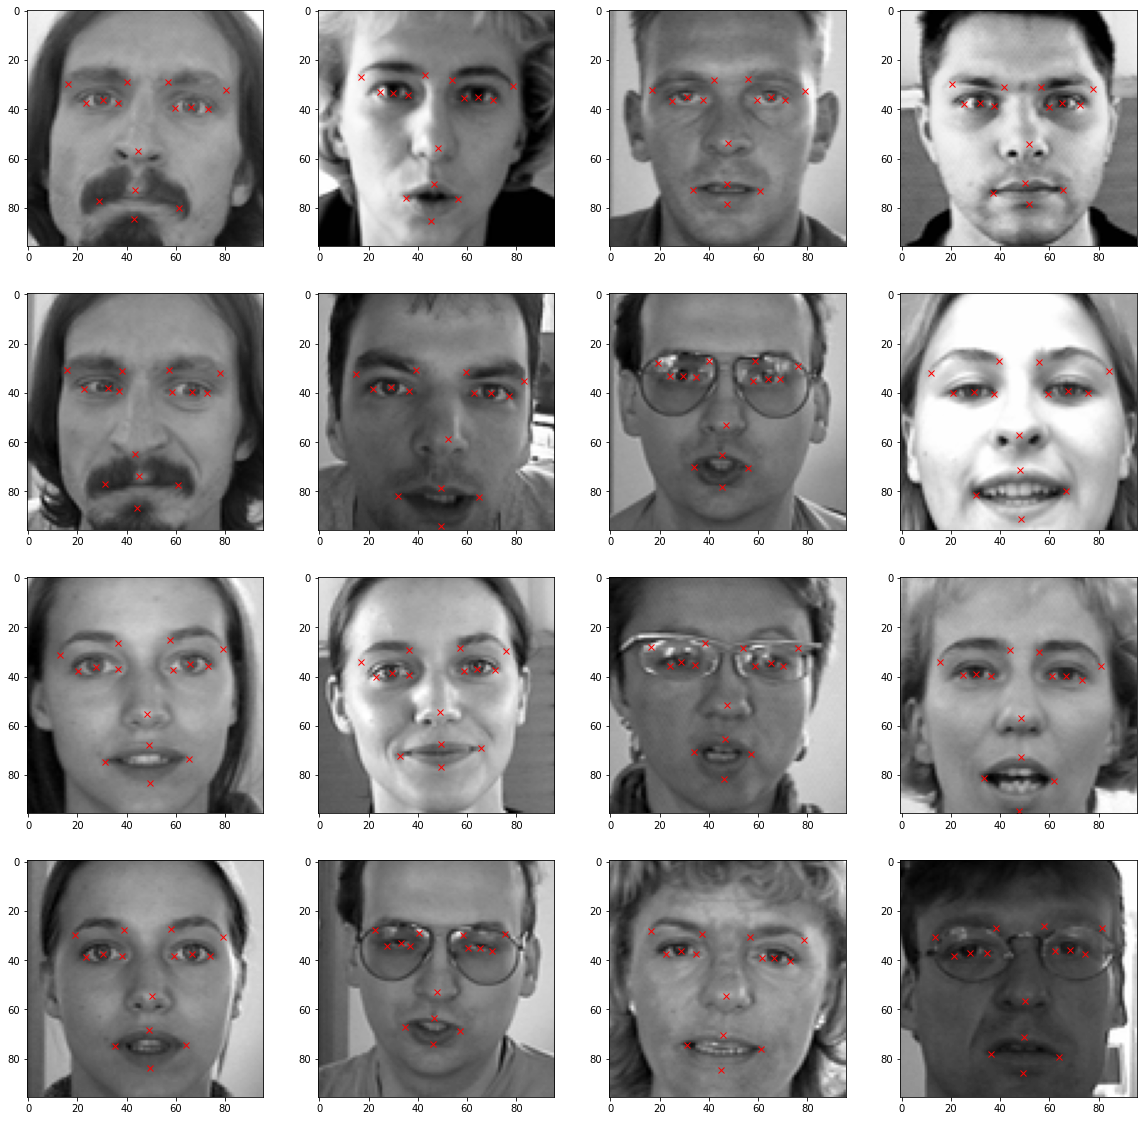

In [8]:
#sanity check for points visualisaction
i = np.random.randint(1, len(facialpoints_df))
plt.figure()
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

# Augmentation
I'll flip them horisontally and vertically and adjust brightnes

In [9]:
facialpoints_df_copy = copy.copy(facialpoints_df)

In [10]:
#flipping images horisontally, adjusting facial points locations
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

In [11]:
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [12]:
#flipping images vertically, adjusting facial points locations
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(columns)):
    if i%2 != 0:
        facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented,facialpoints_df_copy))

In [13]:
facialpoints_df_augmented.shape

(6420, 31)

In [14]:
#adjusting brightness
facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(0.5, 1.5) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(8560, 31)

## Image normalization

In [15]:
img = facialpoints_df_augmented[:, 30]
img = img/255.

#empty array for training data, set image dimentions, convert to float32
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [16]:
#target values, train test split
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


## Construct RezNet18



In [17]:
# residual block
def res_block(X, filter, stage):
    
    # CONVOLUTIONAL BLOCK
    X_copy = X
    f1 , f2, f3 = filter

    # Main Path
    X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # Add data from main and short paths
    X = Add()([X,X_copy])
    X = Activation('relu')(X)



    # IDENTITY BLOCK 1
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # Add both paths together
    X = Add()([X,X_copy])
    X = Activation('relu')(X)



    # IDENTITY BLOCK 2
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # Add both paths together
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [18]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 11, 11, 64)   0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 11, 11, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 11, 11, 256)  1024       ['res_2_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_2 (Add)                    (None, 11, 11, 256)  0           ['bn_2_identity_2_c[0][0]',      
                                                                  'activation_6[0][0]']           
          

                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 5, 5, 512)    66048       ['activation_17[0][0]']          
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 5, 5, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_5 (Add)                    (None, 5, 5, 512)    0           ['bn_3_identity_2_c[0][0]',      
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 5, 5, 512)    0           ['add_5[0][0]']                  
          

In [19]:
#adding custom optimizer
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [20]:
#saving best model
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)

In [21]:
#training
history = model.fit(X_train, y_train, batch_size = 256, epochs= 25, validation_split = 0.2,callbacks=[checkpointer])

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 524.2976 - accuracy: 0.2196
Epoch 1: val_loss improved from inf to 2251.91528, saving model to weights.hdf5
22/22 [==============================] - 73s 3s/step - loss: 524.2976 - accuracy: 0.2196 - val_loss: 2251.9153 - val_accuracy: 0.0219
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 152.6209 - accuracy: 0.5785
Epoch 2: val_loss improved from 2251.91528 to 1909.69531, saving model to weights.hdf5
22/22 [==============================] - 62s 3s/step - loss: 152.6209 - accuracy: 0.5785 - val_loss: 1909.6953 - val_accuracy: 0.5241
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 100.1790 - accuracy: 0.6698
Epoch 3: val_loss improved from 1909.69531 to 1624.39905, saving model to weights.hdf5
22/22 [==============================] - 62s 3s/step - loss: 100.1790 - accuracy: 0.6698 - val_loss: 1624.3990 - val_accuracy: 0.1255
Epoch 4/25
22/22 [==============================] - ETA:

In [22]:
#saving trained model
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

In [23]:
#model evaluation
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [24]:
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 7s 113ms/step - loss: 74.7044 - accuracy: 0.7722
Accuracy : 0.7721962332725525


## Key Facial Points prediction

In [25]:
df_predict = model.predict(X_test)
rms = sqrt(mean_squared_error(y_test, df_predict))
df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

54/54 [==============================] - 7s 112ms/step


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,62.278019,33.939060,28.744503,34.719852,54.747940,35.262375,68.913094,34.524940,36.365471,36.086155,...,41.099464,58.492596,60.609097,74.247559,31.738134,74.957817,44.357216,74.596764,44.707859,77.898445
1,62.131241,35.466869,29.988518,34.118496,56.950508,35.753002,67.152321,36.417294,35.894791,35.077023,...,43.959511,53.664364,56.349751,70.513954,32.626526,68.988434,44.088261,64.932426,43.702641,77.094048
2,41.571640,34.454441,48.673649,34.137787,43.655518,35.244621,39.279495,35.272507,46.994358,35.010452,...,45.057819,51.912224,41.014988,68.054581,48.228756,67.409668,44.477158,64.693863,44.199856,73.912331
3,65.741119,36.700436,26.407286,36.257515,58.334969,37.701351,73.089897,37.803551,34.799007,37.587132,...,46.093422,58.308884,63.189899,77.904205,31.331240,78.288765,46.772041,74.260086,47.273891,85.787331
4,29.093412,57.967617,64.053444,55.716484,35.928284,56.737789,21.721769,57.318199,57.494881,55.857151,...,46.461823,40.546444,28.597523,24.228058,59.219753,22.818975,44.641209,26.683203,44.077309,16.912306


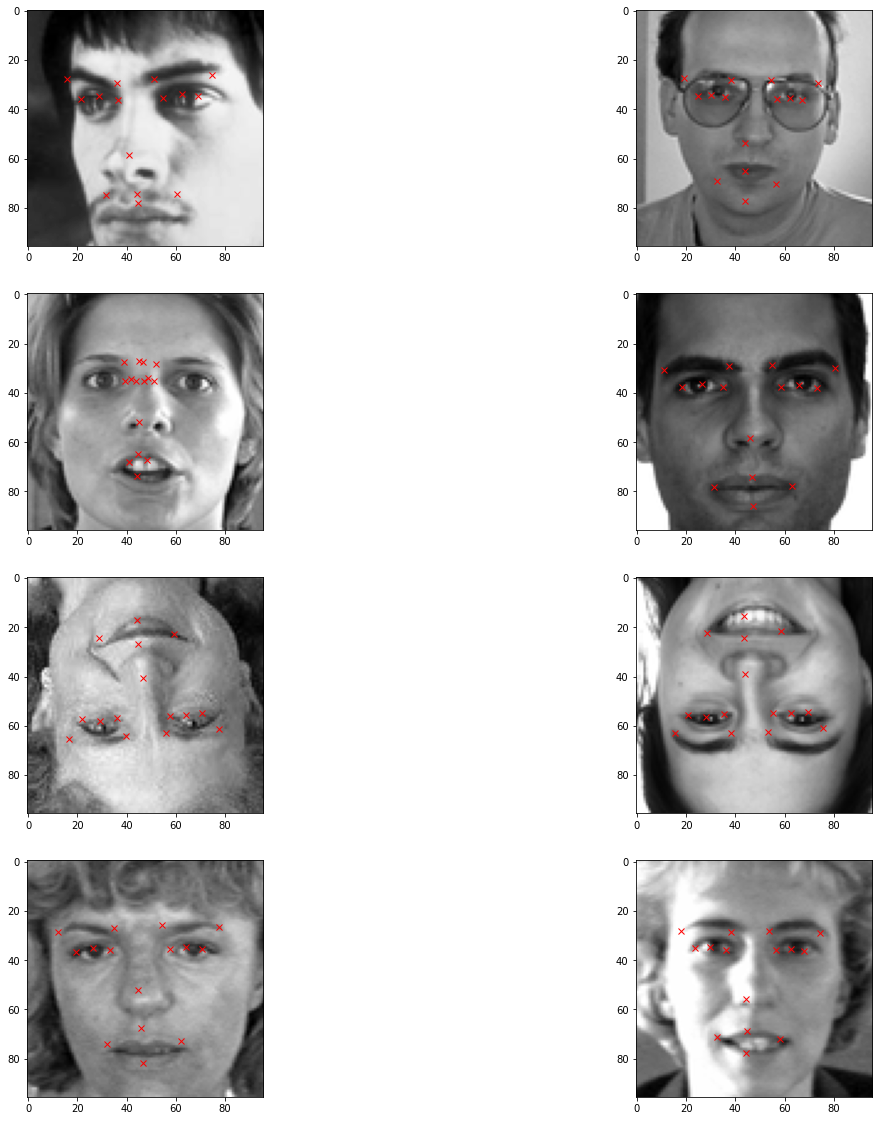

In [26]:
#plotting predicted points
fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')